In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.data.experimental import AUTOTUNE
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import RandomRotation, RandomZoom
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import applications
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

## Reading data

In [2]:
BATCH_SIZE = 32
IMG_SIZE = (128, 128)
SEED = 0

tf.random.set_seed(SEED)

directory = '/kaggle/input/alzheimer-mri-dataset/Dataset'

train_dataset = image_dataset_from_directory(directory=directory,
                                             label_mode='categorical',
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             shuffle=True,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=SEED)

full_validation_dataset = image_dataset_from_directory(directory=directory,
                                                       label_mode='categorical',
                                                       batch_size=BATCH_SIZE,
                                                       image_size=IMG_SIZE,
                                                       shuffle=True,
                                                       validation_split=0.2,
                                                       subset='validation',
                                                       seed=SEED)

Found 6400 files belonging to 4 classes.
Using 5120 files for training.
Found 6400 files belonging to 4 classes.
Using 1280 files for validation.


## Splitting validation and testing datasets

<h4> As we see, the number of full_validation_dataset batches is 40 batch.  </h4>
<h4> And we want to split it into validation and testing datasets each of size 20 batch. </h4>

In [3]:
validation_batches = len(full_validation_dataset)
print(f'Total number of full_validation_dataset batches : {validation_batches}')

validation_dataset = full_validation_dataset.take(validation_batches // 2)
test_dataset = full_validation_dataset.skip(validation_batches // 2)

print(f'Number of batches in validation dataset : {len(validation_dataset)}')
print(f'Number of batches in test dataset : {len(test_dataset)}')

Total number of full_validation_dataset batches : 40
Number of batches in validation dataset : 20
Number of batches in test dataset : 20


In [4]:
class_names = train_dataset.class_names
class_names

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']

## Exploring some samples

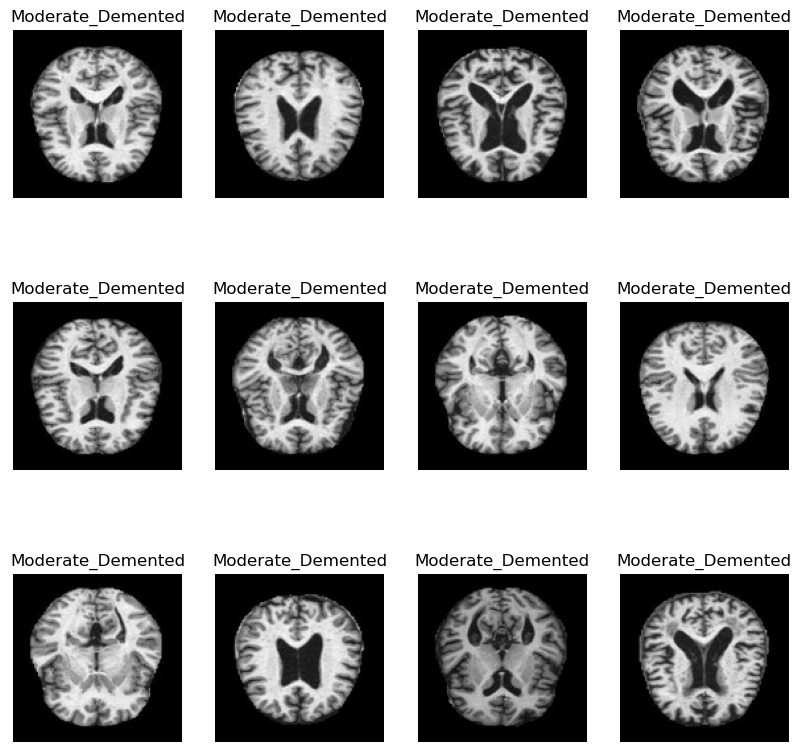

In [5]:
plt.figure(figsize=(10,10))
for images, labels in train_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[int(max(labels[i]))])
        plt.axis('off')

## Preventing a memory bottleneck
<h4> prefetch() function is used to prevent a memory bottleneck that can occur when reading from disk.</h4>
<h4> we use <b>tensorflow.data.experimental.AUTOTUNE</b> to choose the parameters automatically. </h4>

In [6]:
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

## Data Augmentation

In [7]:
def data_augmentar():
    """This function applies two data augmentation techniques.
        First, augmentation with RandomRotation.
        Second, augmentation with RandomZoom
    """
    
    data_augmentation = Sequential()
    data_augmentation.add(RandomRotation(factor=(-0.15, 0.15)))
    data_augmentation.add(RandomZoom((-0.3, -0.1)))
    
    return data_augmentation

In [8]:
data_augmentation = data_augmentar()
assert(data_augmentation.layers[0].name.startswith('random_rotation'))
assert(data_augmentation.layers[0].factor == (-0.15, 0.15))
assert(data_augmentation.layers[1].name.startswith('random_zoom'))
assert(data_augmentation.layers[1].height_factor == (-0.3, -0.1))

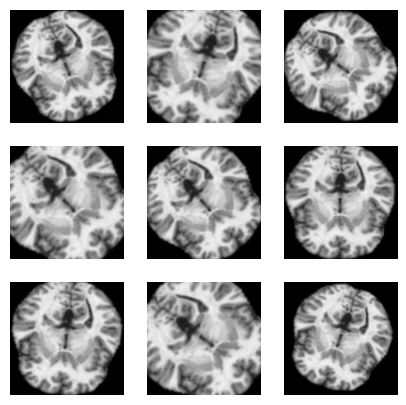

In [9]:
## applying data augmentation with a sample image.

plt.figure(figsize=(5, 5))
for images, labels in train_dataset.take(1):
    image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        augmented_image = data_augmentation(image)
        plt.imshow(augmented_image.numpy().astype('uint8'), cmap='gray')
        plt.axis('off')

## Solving Imbalanced Data Problem

In [10]:
## Calculate number of samples in each class.

class_counts = dict()
for folder in class_names:
    class_counts[folder] = len(os.listdir(directory+'/'+folder))

class_counts

{'Mild_Demented': 896,
 'Moderate_Demented': 64,
 'Non_Demented': 3200,
 'Very_Mild_Demented': 2240}

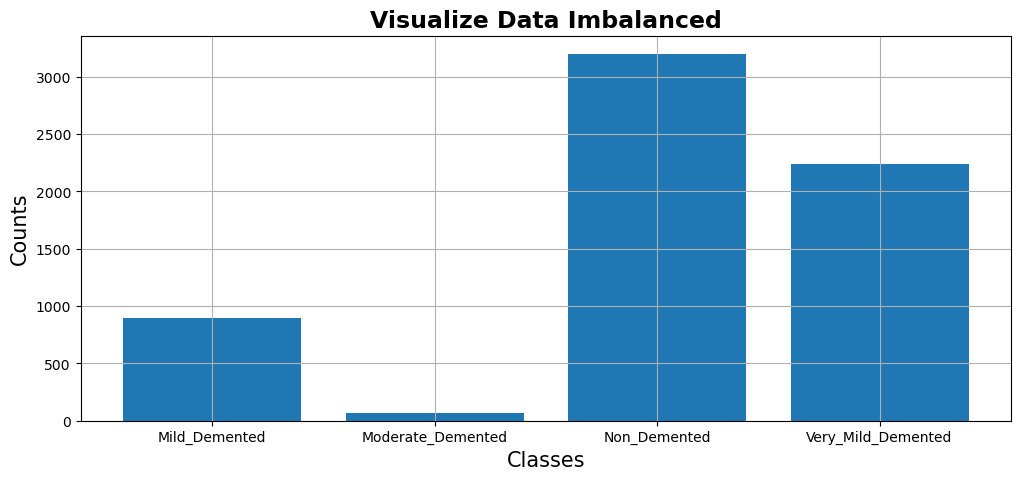

In [11]:
plt.figure(figsize=(12,5))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Classes', fontdict={'fontsize':15})
plt.ylabel('Counts', fontdict={'fontsize':15})
plt.title('Visualize Data Imbalanced', fontdict={'fontsize':17,
                                                 'fontweight':'bold'})
plt.grid(True)
plt.show()

In [12]:
## Calculate class weights.

total = sum(class_counts.values())
number_of_classes = len(class_counts)

class_weights = dict()
for i in range(number_of_classes):
    class_weights[i] = round(total / (number_of_classes * list(class_counts.values())[i]), 2)
    print(f'Weight for class \"{class_names[i]}\" : {class_weights[i]}')

Weight for class "Mild_Demented" : 1.79
Weight for class "Moderate_Demented" : 25.0
Weight for class "Non_Demented" : 0.5
Weight for class "Very_Mild_Demented" : 0.71


In [13]:
preprocess_input = applications.efficientnet.preprocess_input

In [14]:
model = applications.EfficientNetB0(include_top=False)
len(model.layers)

16705208/16705208 [==============================] - 0s 0us/step


238

In [15]:
def alzheimer_classifier(image_shape=IMG_SIZE, data_augmentation=data_augmentar()):
    """This function creates a classifier for Alzheimer disease MRI images.
    
    Arguments:
        image_shape-> the size of the image in the form (height, width).
        data_augmentation-> the data augmentation object to apply on the training data.
        
    Returns:
        model-> the created classifier.
    """
    IMG_SHAPE = image_shape + (3,)
    base_model = applications.EfficientNetB0(input_shape=IMG_SHAPE,
                                             include_top=False, 
                                             weights='imagenet')
    
    base_model.trainable = True
    for layer in base_model.layers[0:218]:
        layer.trainable = False
    
    inputs = Input(shape=IMG_SHAPE)
    x = data_augmentation(inputs)
    x = preprocess_input(inputs)
    x = base_model(x)
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(units=4, activation = "softmax")(x)
    
    model = Model(inputs, outputs)
    
    return model

In [16]:
alzheimer_model = alzheimer_classifier(IMG_SIZE, data_augmentation)

In [17]:
alzheimer_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 4, 4, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 4)                 5124      
                                                                 
Total params: 4,054,695
Trainable params: 1,356,084
Non-trainable params: 2,698,611
_________________________________________________________________


In [18]:
lr = 0.001
alzheimer_model.compile(loss=CategoricalCrossentropy(),
                        optimizer=Adam(learning_rate=lr),
                        metrics=['accuracy'])

In [19]:
history = alzheimer_model.fit(train_dataset, 
                              validation_data = validation_dataset,
                              epochs = 50,
                              class_weight=class_weights,
                              use_multiprocessing=True)

Epoch 1/50
160/160 [==============================] - 102s 577ms/step - loss: 1.1667 - accuracy: 0.4529 - val_loss: 0.8384 - val_accuracy: 0.5922
Epoch 2/50
160/160 [==============================] - 90s 563ms/step - loss: 0.7541 - accuracy: 0.5928 - val_loss: 0.7787 - val_accuracy: 0.6469
Epoch 3/50
160/160 [==============================] - 91s 568ms/step - loss: 0.5909 - accuracy: 0.6691 - val_loss: 0.7435 - val_accuracy: 0.6687
Epoch 4/50
160/160 [==============================] - 90s 559ms/step - loss: 0.5251 - accuracy: 0.7107 - val_loss: 0.6495 - val_accuracy: 0.7188
Epoch 5/50
160/160 [==============================] - 88s 552ms/step - loss: 0.3765 - accuracy: 0.7904 - val_loss: 0.4478 - val_accuracy: 0.8156
Epoch 6/50
160/160 [==============================] - 90s 561ms/step - loss: 0.3018 - accuracy: 0.8273 - val_loss: 0.5158 - val_accuracy: 0.7766
Epoch 7/50
160/160 [==============================] - 90s 562ms/step - loss: 0.2923 - accuracy: 0.8436 - val_loss: 0.5980 - val_a

In [20]:
test_loss, test_accuracy = alzheimer_model.evaluate(test_dataset)

print(f'Test Loss = {test_loss:.2f}')
print(f'Test Accuracy = {test_accuracy:.2f}')

20/20 [==============================] - 9s 416ms/step - loss: 0.0856 - accuracy: 0.9734
Test Loss = 0.09
Test Accuracy = 0.97


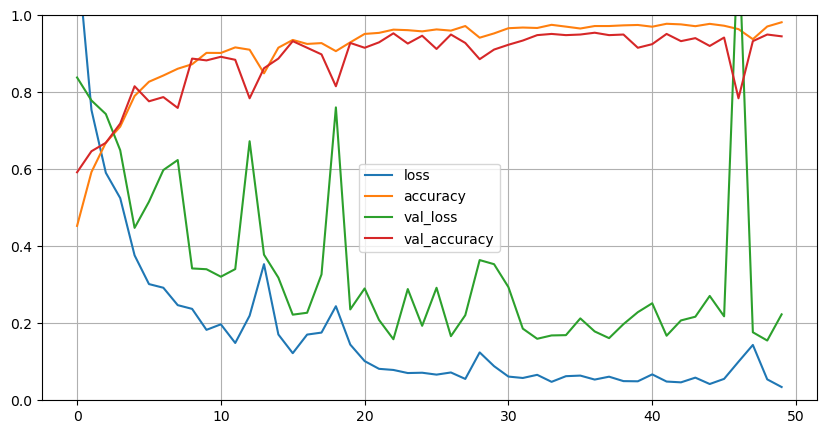

In [21]:
pd.DataFrame(history.history).plot(figsize=(10,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()